In [2]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

2021-09-05 19:04:23.643346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-05 19:04:23.643377: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
BATCH_SIZE = 16

In [4]:
def get_image_from_string(image_pixels_string):
    
    image_pixels_list = [int(point) for point in image_pixels_string.split(" ")]
    image_side = int(np.sqrt(len(image_pixels_list)))
    image = np.reshape(image_pixels_list, (image_side, image_side))
#     image = np.expand_dims(image, 2)
    image = np.stack([image, image, image], axis=2)
    
    return image

def display_image(image):
    
    plt.figure()
    plt.imshow(image.astype(np.uint8))
#     , cmap="gray"
    return

def get_image_keypoints(index):
    
    keypoints = train_df.iloc[index][:-1].values
    
    return keypoints

def draw_keypoints(image, keypoints):
    
    for i in np.linspace(0, len(keypoints)-2, 15, dtype=int):
        if math.isnan(keypoints[i]) or math.isnan(keypoints[i+1]):
            continue
        if keypoints[i] < 0 or keypoints[i] > 95:
            continue
        if keypoints[i+1] < 0 or keypoints[i+1] > 95:
            continue
        image[int(keypoints[i+1]), int(keypoints[i])] = 255
        
    return image

In [5]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, images, keypoints, augmentations, batch_size, shuffle=True):
        
        self.images = images
        self.keypoints = keypoints
        self.augmentations = augmentations
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        images = [self.images[k] for k in indexes]
        keypoints = [self.keypoints[k] for k in indexes]
        images, keypoints = self.__data_generation(images, keypoints)

        return (images, keypoints)

    def __data_generation(self, images, keypoints):
        
        len_image_side = images[0].shape[0]
        len_keypoints = len(keypoints[0])
        batch_images = np.empty((self.batch_size, len_image_side, len_image_side, 3), dtype="float32")
        batch_keypoints = np.empty((self.batch_size, len_keypoints), dtype="float32")

        for i, (image, keypoint) in enumerate(zip(images, keypoints)):
            keypoint_pairs = []
            
            for j in np.arange(0, len(keypoint), 2):
                keypoint_pairs.append(Keypoint(x=int(keypoint[j]), y=int(keypoint[j+1])))
            
            kps_obj = KeypointsOnImage(keypoint_pairs, shape=image.shape)
            (new_image, new_kps_obj) = self.augmentations(image=image, keypoints=kps_obj)
            batch_images[i] = new_image
            kp_temp = []

            for keypoint in new_kps_obj:
                kp_x = np.nan_to_num(keypoint.x)
                kp_y = np.nan_to_num(keypoint.y)
                
                if kp_x < 0 or kp_x > 95:
                    kp_x = 0
                if kp_y < 0 or kp_y > 95:
                    kp_y = 0
                    
                kp_temp.append(kp_x)
                kp_temp.append(kp_y)

            batch_keypoints[i] = kp_temp
        
        return batch_images, batch_keypoints

In [6]:
train_df = pd.read_csv("../data/training.csv")

In [7]:
train_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [8]:
train_df = train_df.fillna(0)

In [9]:
no_rows, no_columns = train_df.shape

In [10]:
labels = []

for i in range(no_rows):
    labels.append(train_df.iloc[i][:-1].values.astype(float))

In [11]:
images = []

for i in range(no_rows):
    images.append(get_image_from_string(train_df.iloc[i]["Image"]).astype(float))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

In [13]:
train_aug = iaa.Sequential([iaa.Resize(X_train[0].shape[0:2], interpolation="linear"), iaa.Fliplr(0.5), iaa.Sometimes(0.5, iaa.Affine(rotate=(-15, 15), scale=(0.5, 1.5)))])
test_aug = iaa.Sequential([iaa.Resize(X_train[0].shape[0:2], interpolation="linear")])

In [14]:
train_dataset = KeyPointsDataset(X_train, y_train, train_aug, BATCH_SIZE)
val_dataset = KeyPointsDataset(X_train, y_train, test_aug, BATCH_SIZE)

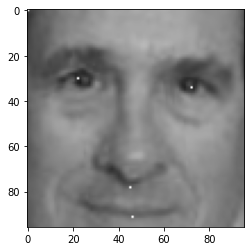

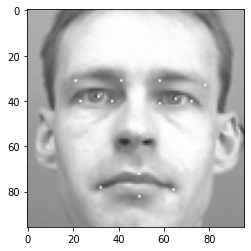

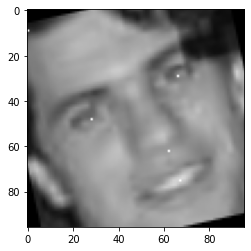

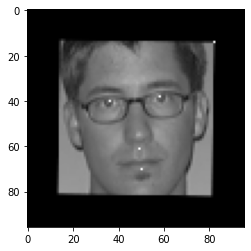

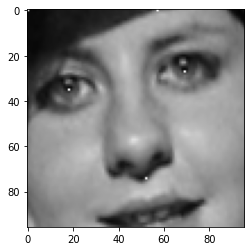

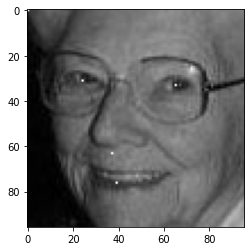

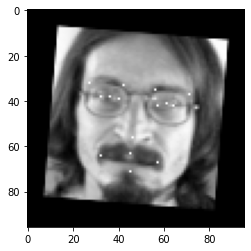

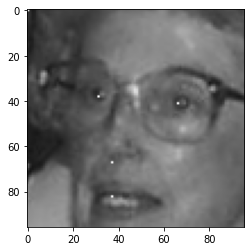

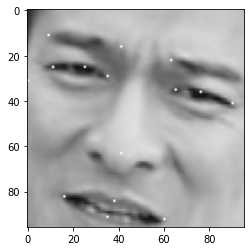

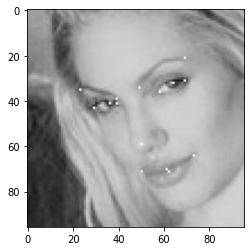

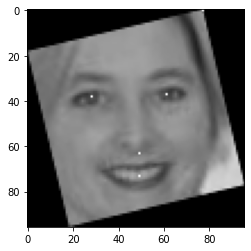

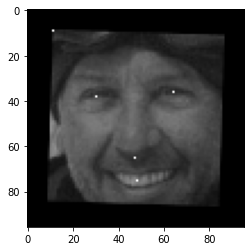

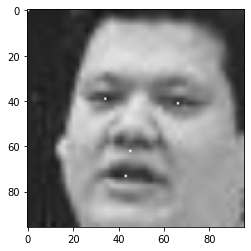

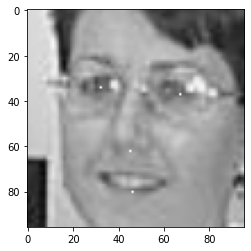

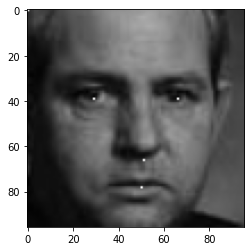

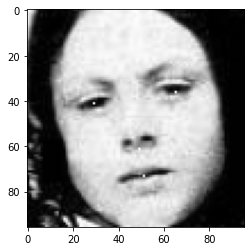

In [15]:
count = 0

for images, labels in train_dataset:
    count += 1
    
    for image, label in zip(images, labels):
        image_w_keypoints = draw_keypoints(image.copy(), label)
        display_image(image_w_keypoints)
    
    if count == 1:
        break

In [16]:
def get_model(base_trainable=False):
    
    base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(96, 96, 3))
    base_model.trainable = base_trainable
    
    inputs = tf.keras.Input(shape=(96, 96, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(30)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [17]:
model = get_model()

2021-09-05 19:04:48.194316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-05 19:04:48.194345: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-05 19:04:48.194363: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ali-Latitude-E5470): /proc/driver/nvidia/version does not exist
2021-09-05 19:04:48.194532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", monitor="val_loss", save_best_only=True),
]

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

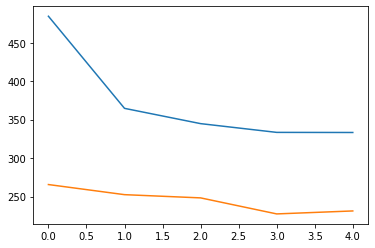

In [26]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# model = tf.keras.models.load_model('save_at_18.h5')

In [19]:
X_val_tensor = tf.convert_to_tensor(X_val)
predictions = model.predict(X_val_tensor)

2021-09-05 19:05:15.094515: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-05 19:05:15.114732: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499950000 Hz


In [20]:
X_val_tensor.shape

TensorShape([705, 96, 96, 3])

In [ ]:
count = 0
for image, prediction in zip(X_val, predictions):
    count += 1
    if count == 10:
    break
    # display_image(image.copy())
    display_image(draw_keypoints(image.copy(), prediction))

In [ ]:
model.summary()

In [ ]:
model.layers[3].trainable = True

In [ ]:
model.summary()

In [ ]:
# model = tf.keras.models.load_model('drive/MyDrive/finetuned_save_at_7.h5')

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("finetuned_2_save_at_{epoch}.h5", monitor="val_loss", save_best_only=True),
]

In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.0003))

In [ ]:
history = model.fit(train_dataset, callbacks=callbacks, validation_data=val_dataset, epochs=20)

In [ ]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [50]:
predictions = model.predict(X_val_tensor)

/tmp/ipykernel_6755/314378794.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


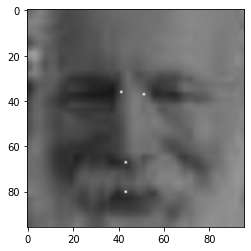

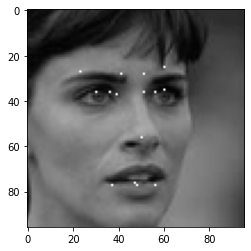

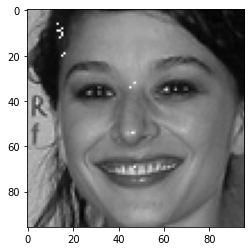

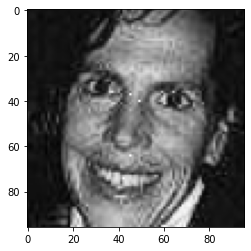

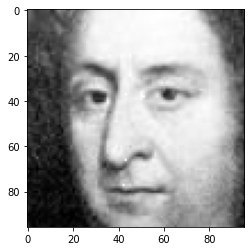

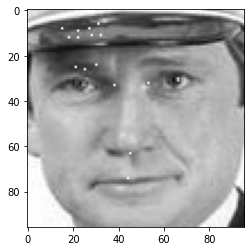

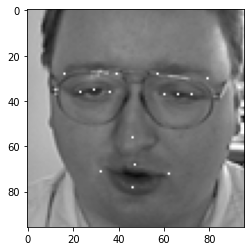

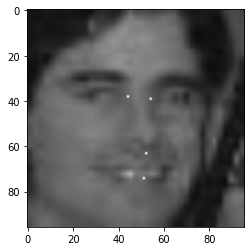

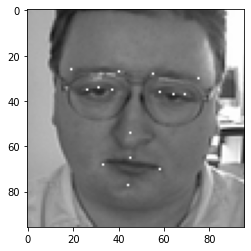

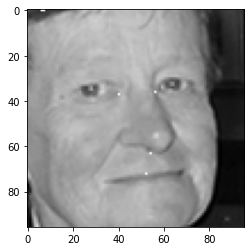

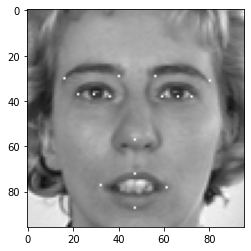

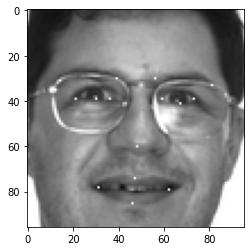

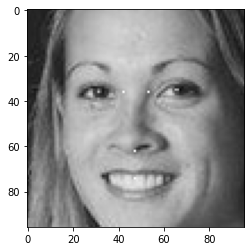

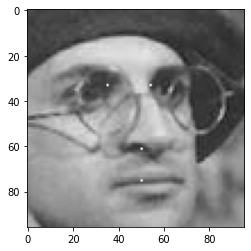

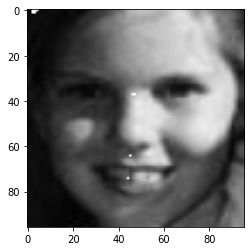

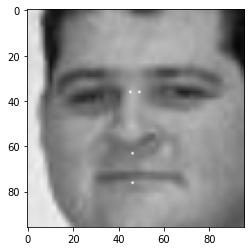

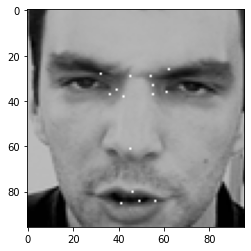

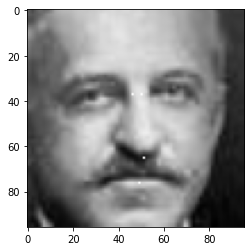

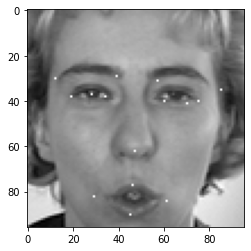

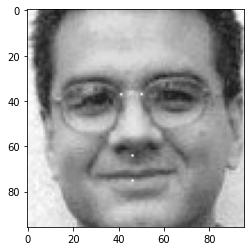

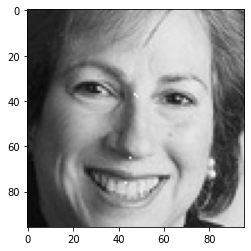

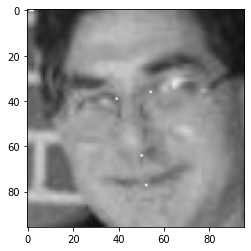

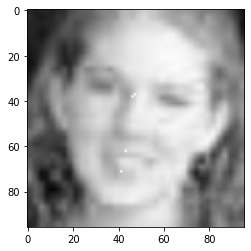

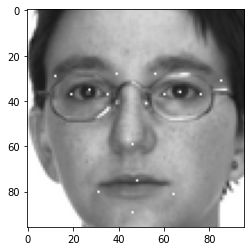

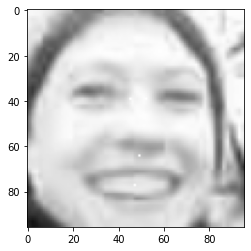

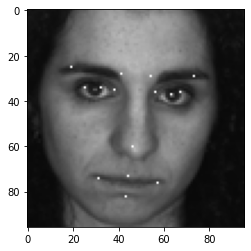

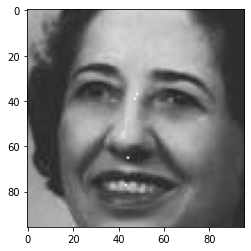

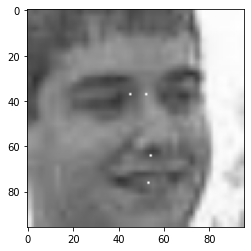

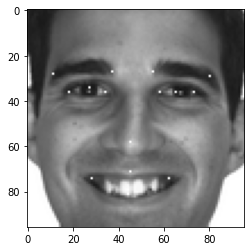

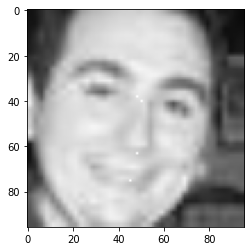

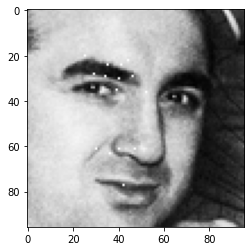

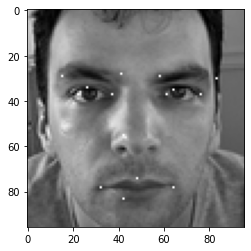

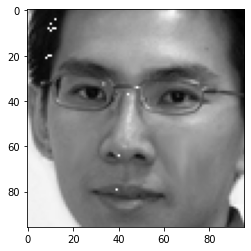

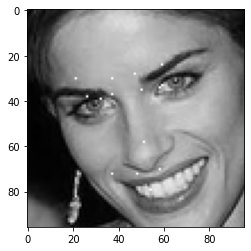

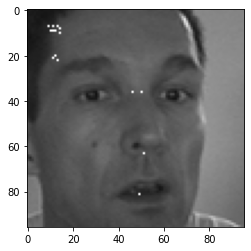

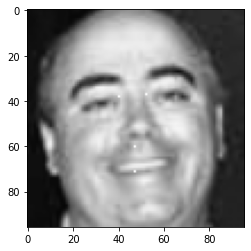

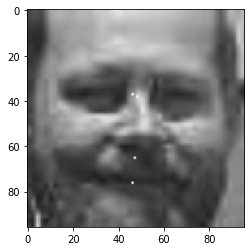

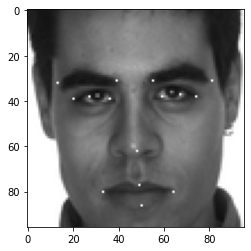

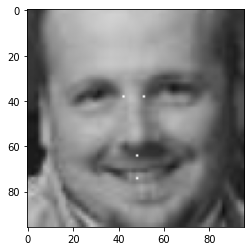

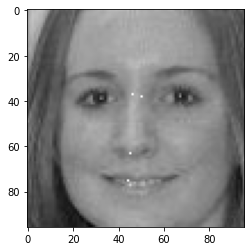

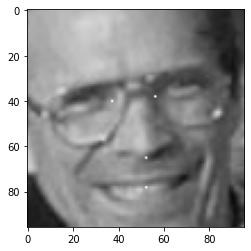

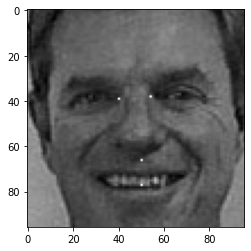

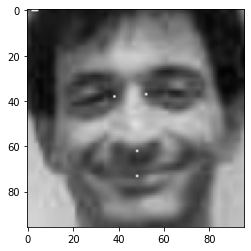

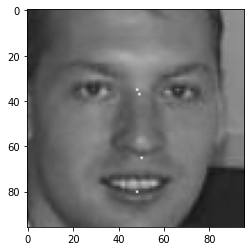

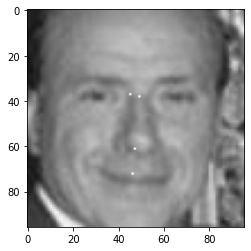

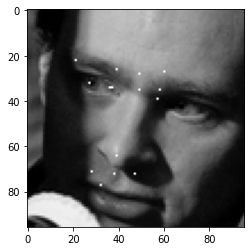

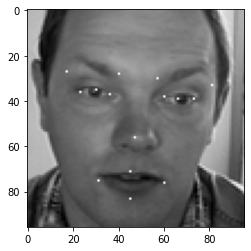

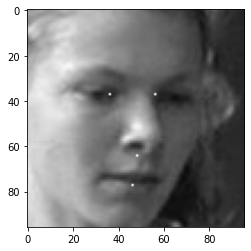

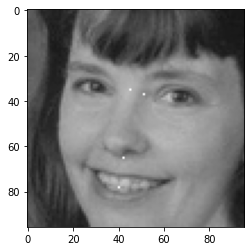

In [51]:
count = 0
for image, prediction in zip(X_val, predictions):
    count += 1
    if count == 50:
        break
    display_image(draw_keypoints(image.copy(), prediction))